In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import numpy as np
import pandas as pd
import dask.dataframe as dd

from dateutil.rrule import HOURLY
from zoneinfo import ZoneInfo

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time
from astropy.time import TimeDelta

from lsst_efd_client import EfdClient

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Read the Gemini data

In [2]:
gemini = dd.read_csv('/home/cwalter/DATA/2022-*_GeminiDimm.csv', parse_dates=['date,time']).compute()

# Rename column to indicate it is from Gemini and resample at a 10 minute interval

gemini.rename(columns = {'Fwhm':'gemini_fwhm'}, inplace = True)
gemini.set_index("date,time", inplace=True)
gemini.index = gemini.index.tz_localize('America/Santiago')
gemini = gemini.resample('10min').mean()

In [3]:
%%script echo Skipping Cell 

with pd.option_context('display.max_rows', 30, 'display.max_colwidth', 120):
    display(gemini)

gemini.gemini_fwhm.plot(style='.-')

Skipping Cell


# Read the EFD

OBSERVATIONS ON 

2 - 16, 17, 18  
3 - 15*, 16, 17  
4 - 5, 6, 7  
5 - 3, 4, 5  
5 - 25, 26, 27  
6 - 7, 8, 9  

\* = No EFD Data

## Get the DIMM data

In [54]:
# Set the date
month = 4
day = 7
year = 2022

In [55]:
efd_client = EfdClient('summit_efd')

time_start = Time(f'{year}-{month}-{day}T20:00') # This time in UTC
time_end = TimeDelta(0.75, format='jd')

dimm = await efd_client.select_time_series(
        'lsst.sal.DIMM.logevent_dimmMeasurement', 
        fields=['fwhm', 'fhwmx', 'fwhmy'], 
        start=time_start, 
        end=time_end)

# Rename column to indicate it is from Rubin, get rid of missing data,
# and resample at a 10 minute interval

dimm.rename(columns = {'fwhm':'rubin_fwhm'}, inplace = True)
dimm.dropna(subset=['rubin_fwhm'], inplace=True)
dimm = dimm.resample('10min').mean()
dimm.index = dimm.index.tz_convert('America/Santiago')

In [56]:
%%script echo Skipping Cell

with pd.option_context('display.max_rows', 20, 'display.max_colwidth', 120):
    display(dimm)

Skipping Cell


## Get the wind data

In [57]:
wind_speed = await efd_client.select_time_series(
        'lsst.sal.WeatherStation.windSpeed', 
        fields=['value'], 
        start=time_start, 
        end=time_end)

wind_direction = await efd_client.select_time_series(
        'lsst.sal.WeatherStation.windDirection', 
        fields=['value'], 
        start=time_start, 
        end=time_end)

# Rename columns and resample at a 10 minute interval

wind_speed.rename(columns = {'value':'wind_speed'}, inplace = True)
wind_direction.rename(columns = {'value':'wind_direction'}, inplace = True)

wind_speed.index = wind_speed.index.tz_convert('America/Santiago')
wind_direction.index = wind_direction.index.tz_convert('America/Santiago')

wind_speed = wind_speed.resample('10min').mean()
wind_direction = wind_direction.resample('10min').mean()

# Make another set of variables for wind quiver plot

wind_speed_20 = wind_speed.resample('20min').mean()
wind_direction_20 = wind_direction.resample('20min').mean()

x = wind_direction_20.index
y = np.zeros(wind_direction_20.size)
radians = np.radians(wind_direction_20.wind_direction)
x_direct = wind_speed_20.wind_speed*np.cos(radians)
y_direct = wind_speed_20.wind_speed*np.sin(radians)

In [58]:
# Fancy stuff to make a nice looking date axis like pandas does
# I need this since I can't make the quiver plot in Pandas.

def fancy_date_axis(axis):

    time_zone = ZoneInfo('America/Santiago')
    locator = mdates.AutoDateLocator(tz=time_zone)
    locator.intervald[HOURLY] = [3]
    zfmts = ['', '%b\n%Y', '%b', '%H:%M\n%d-%b', '%H:%M', '%H:%M']
    formatter = mdates.ConciseDateFormatter(locator, zero_formats=zfmts, tz=time_zone, show_offset=False)
    axis.xaxis.set_major_locator(locator)
    axis.xaxis.set_major_formatter(formatter)

Text(0.5, 0.01, 'Time of observation')

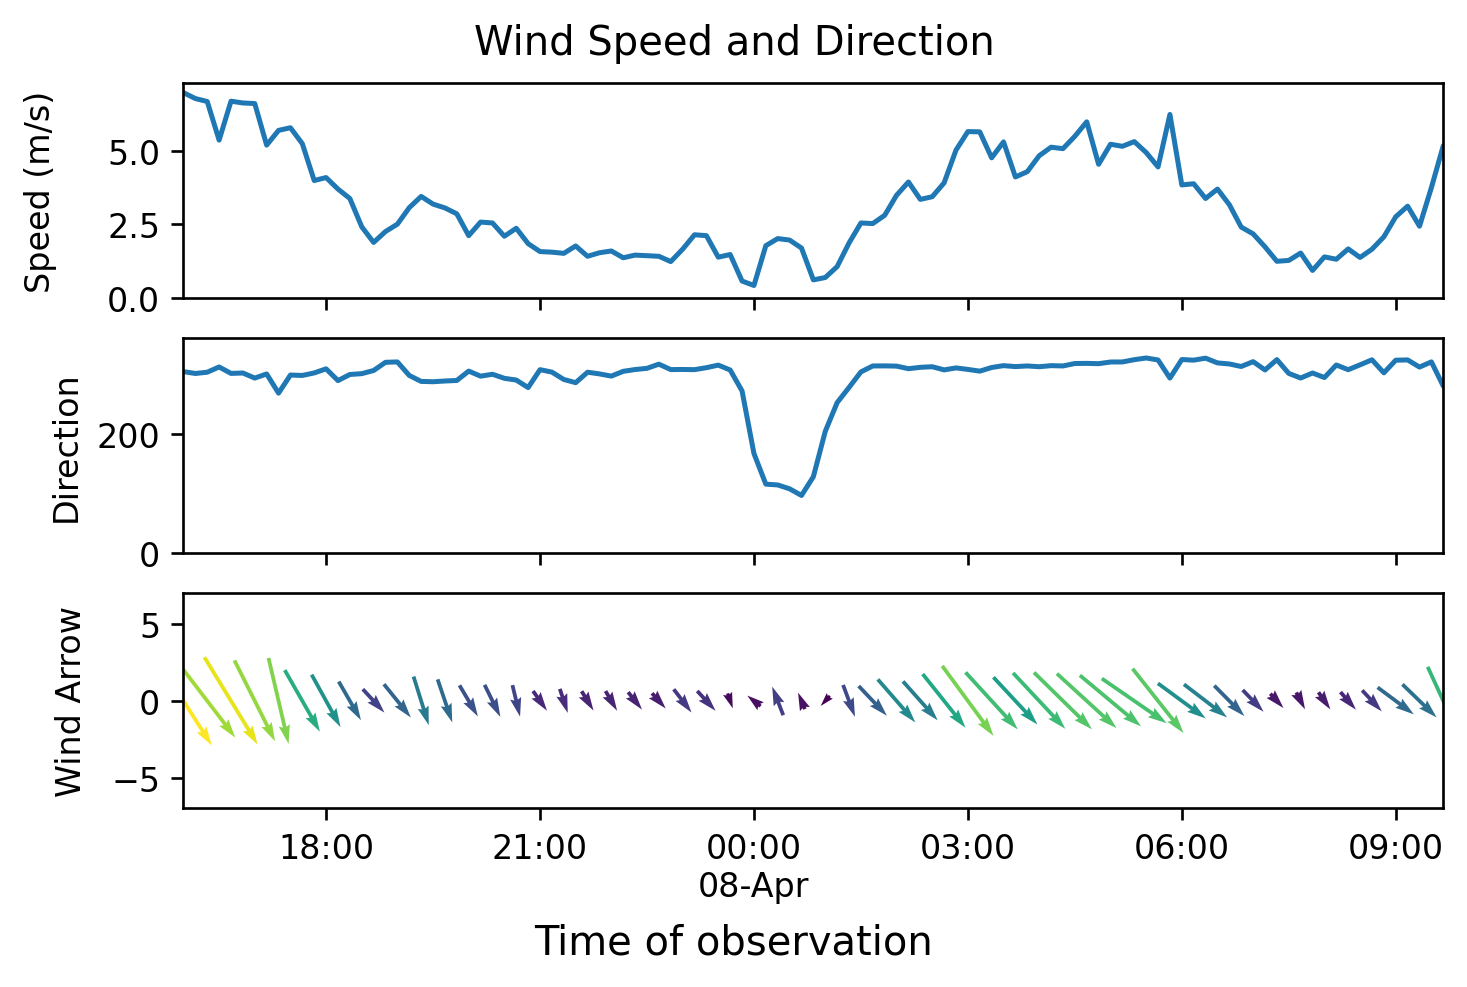

In [59]:
fig, axes = plt.subplot_mosaic('A;B;C', sharex=True, sharey=False, constrained_layout=True)
axes['A'].plot(wind_speed)
axes['B'].plot(wind_direction)
axes['C'].quiver(x, y, x_direct.values, y_direct.values, wind_speed_20.values, angles='uv', scale_units='y', scale=1, width=0.003, pivot='mid')

axes['A'].set_ylim(0)
axes['B'].set_ylim(0,360)

fancy_date_axis(axes['C'])
axes['C'].set_xlim(x[0], x[-1])
axes['C'].set_ylim(-7,7)

axes['A'].set_ylabel("Speed (m/s)", labelpad=15)
axes['B'].set_ylabel("Direction")
axes['C'].set_ylabel("Wind Arrow", labelpad=7)

fig.suptitle(r'Wind Speed and Direction')
fig.supxlabel("Time of observation")

## Make a merged data frame for analysis

In [60]:
merged = pd.merge(dimm['rubin_fwhm'], gemini['gemini_fwhm'], left_index=True, right_index=True)
merged = pd.merge(merged, wind_speed, left_index=True, right_index=True)
merged = pd.merge(merged, wind_direction, left_index=True, right_index=True)
merged = merged.assign(dimm_diff = lambda x: x.rubin_fwhm - x.gemini_fwhm)

#merged

Text(0.5, 0.01, 'Time of observation')

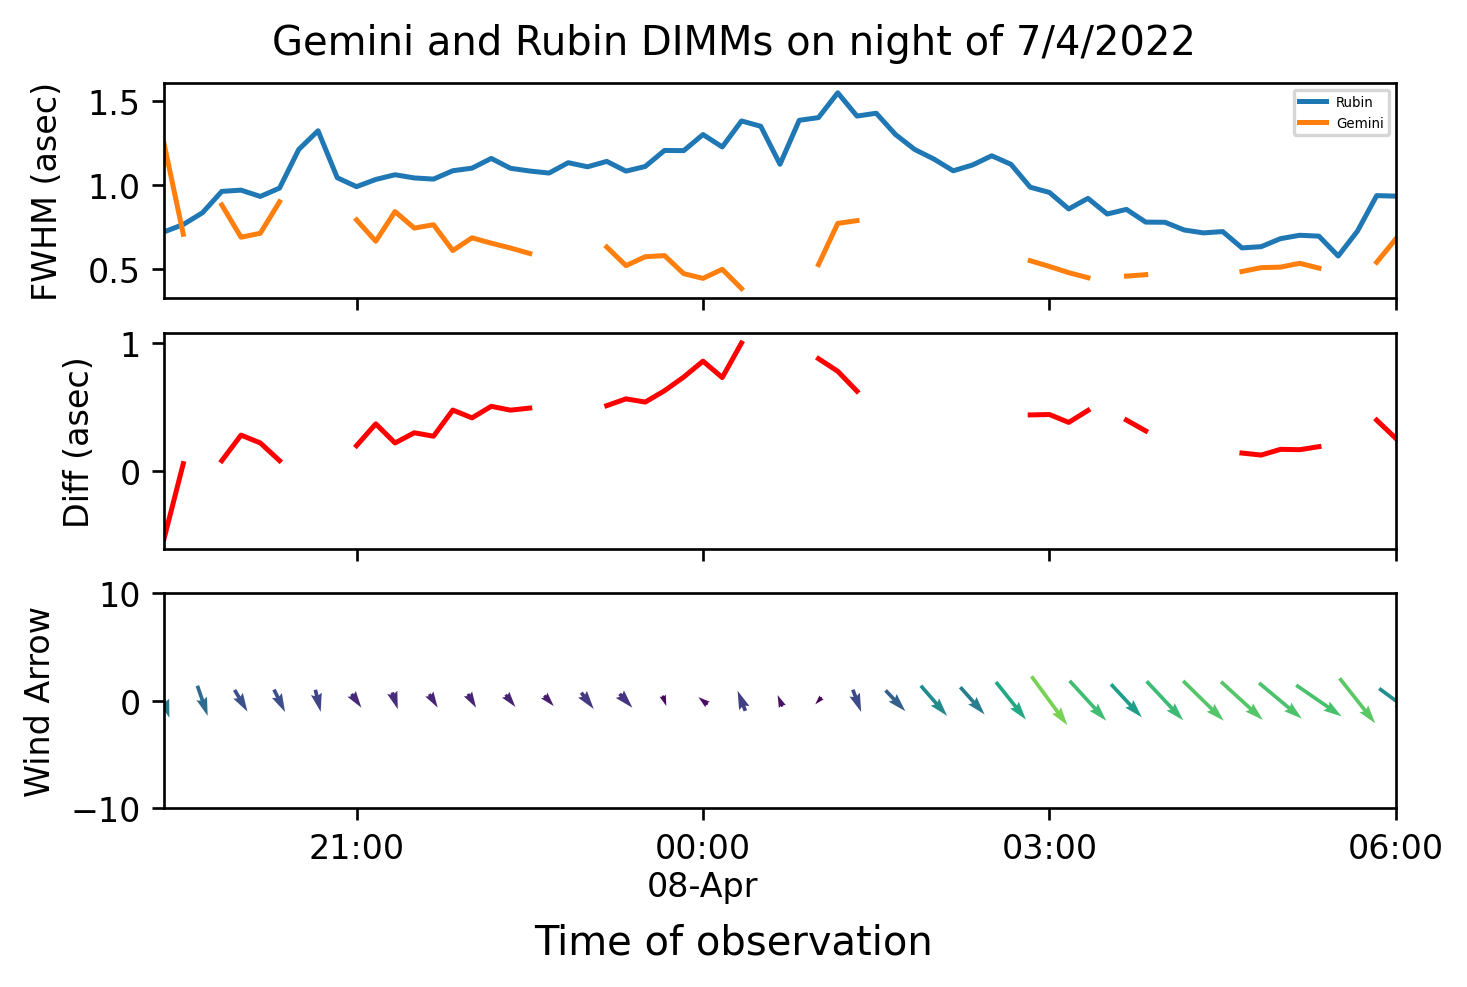

In [61]:
fig, axes = plt.subplot_mosaic('A;B;C', sharex=True, sharey=False, constrained_layout=True)

axes['A'].plot(merged.rubin_fwhm, label='Rubin')
axes['A'].plot(merged.gemini_fwhm, label='Gemini')
axes['B'].plot(merged.dimm_diff,color='r' )
axes['C'].quiver(x, y, x_direct.values, y_direct.values, wind_speed_20.values, angles='uv', scale_units='y', scale=1, width=0.003, pivot='mid')

fancy_date_axis(axes['C'])
axes['C'].set_xlim(merged.rubin_fwhm.index[0], merged.rubin_fwhm.index[-1])
axes['C'].set_ylim(-10,10);

axes['A'].legend(fontsize=4)
axes['A'].set_ylabel(r'FWHM (asec)', labelpad=7)
axes['B'].set_ylabel('Diff (asec)', labelpad=7)
axes['C'].set_ylabel("Wind Arrow")

fig.suptitle(f'Gemini and Rubin DIMMs on night of {day}/{month}/{year}')
fig.supxlabel("Time of observation")

(0.0, 360.0)

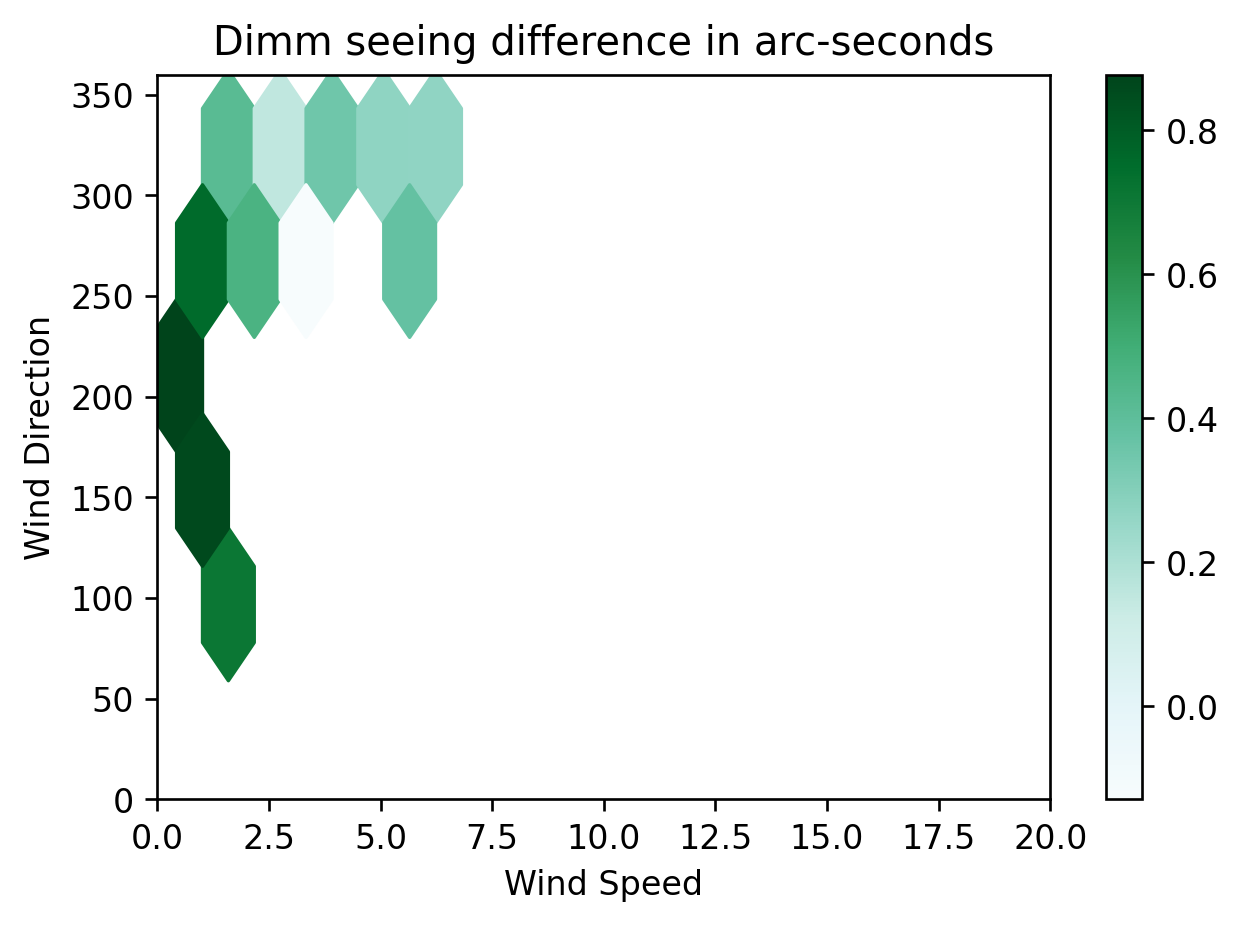

In [62]:
merged.plot.hexbin(x='wind_speed',y='wind_direction', C='dimm_diff', gridsize=5, sharex=False)
plt.xlabel('Wind Speed')
plt.ylabel('Wind Direction')
plt.title('Dimm seeing difference in arc-seconds')
plt.xlim(0, 20)
plt.ylim(0, 360)

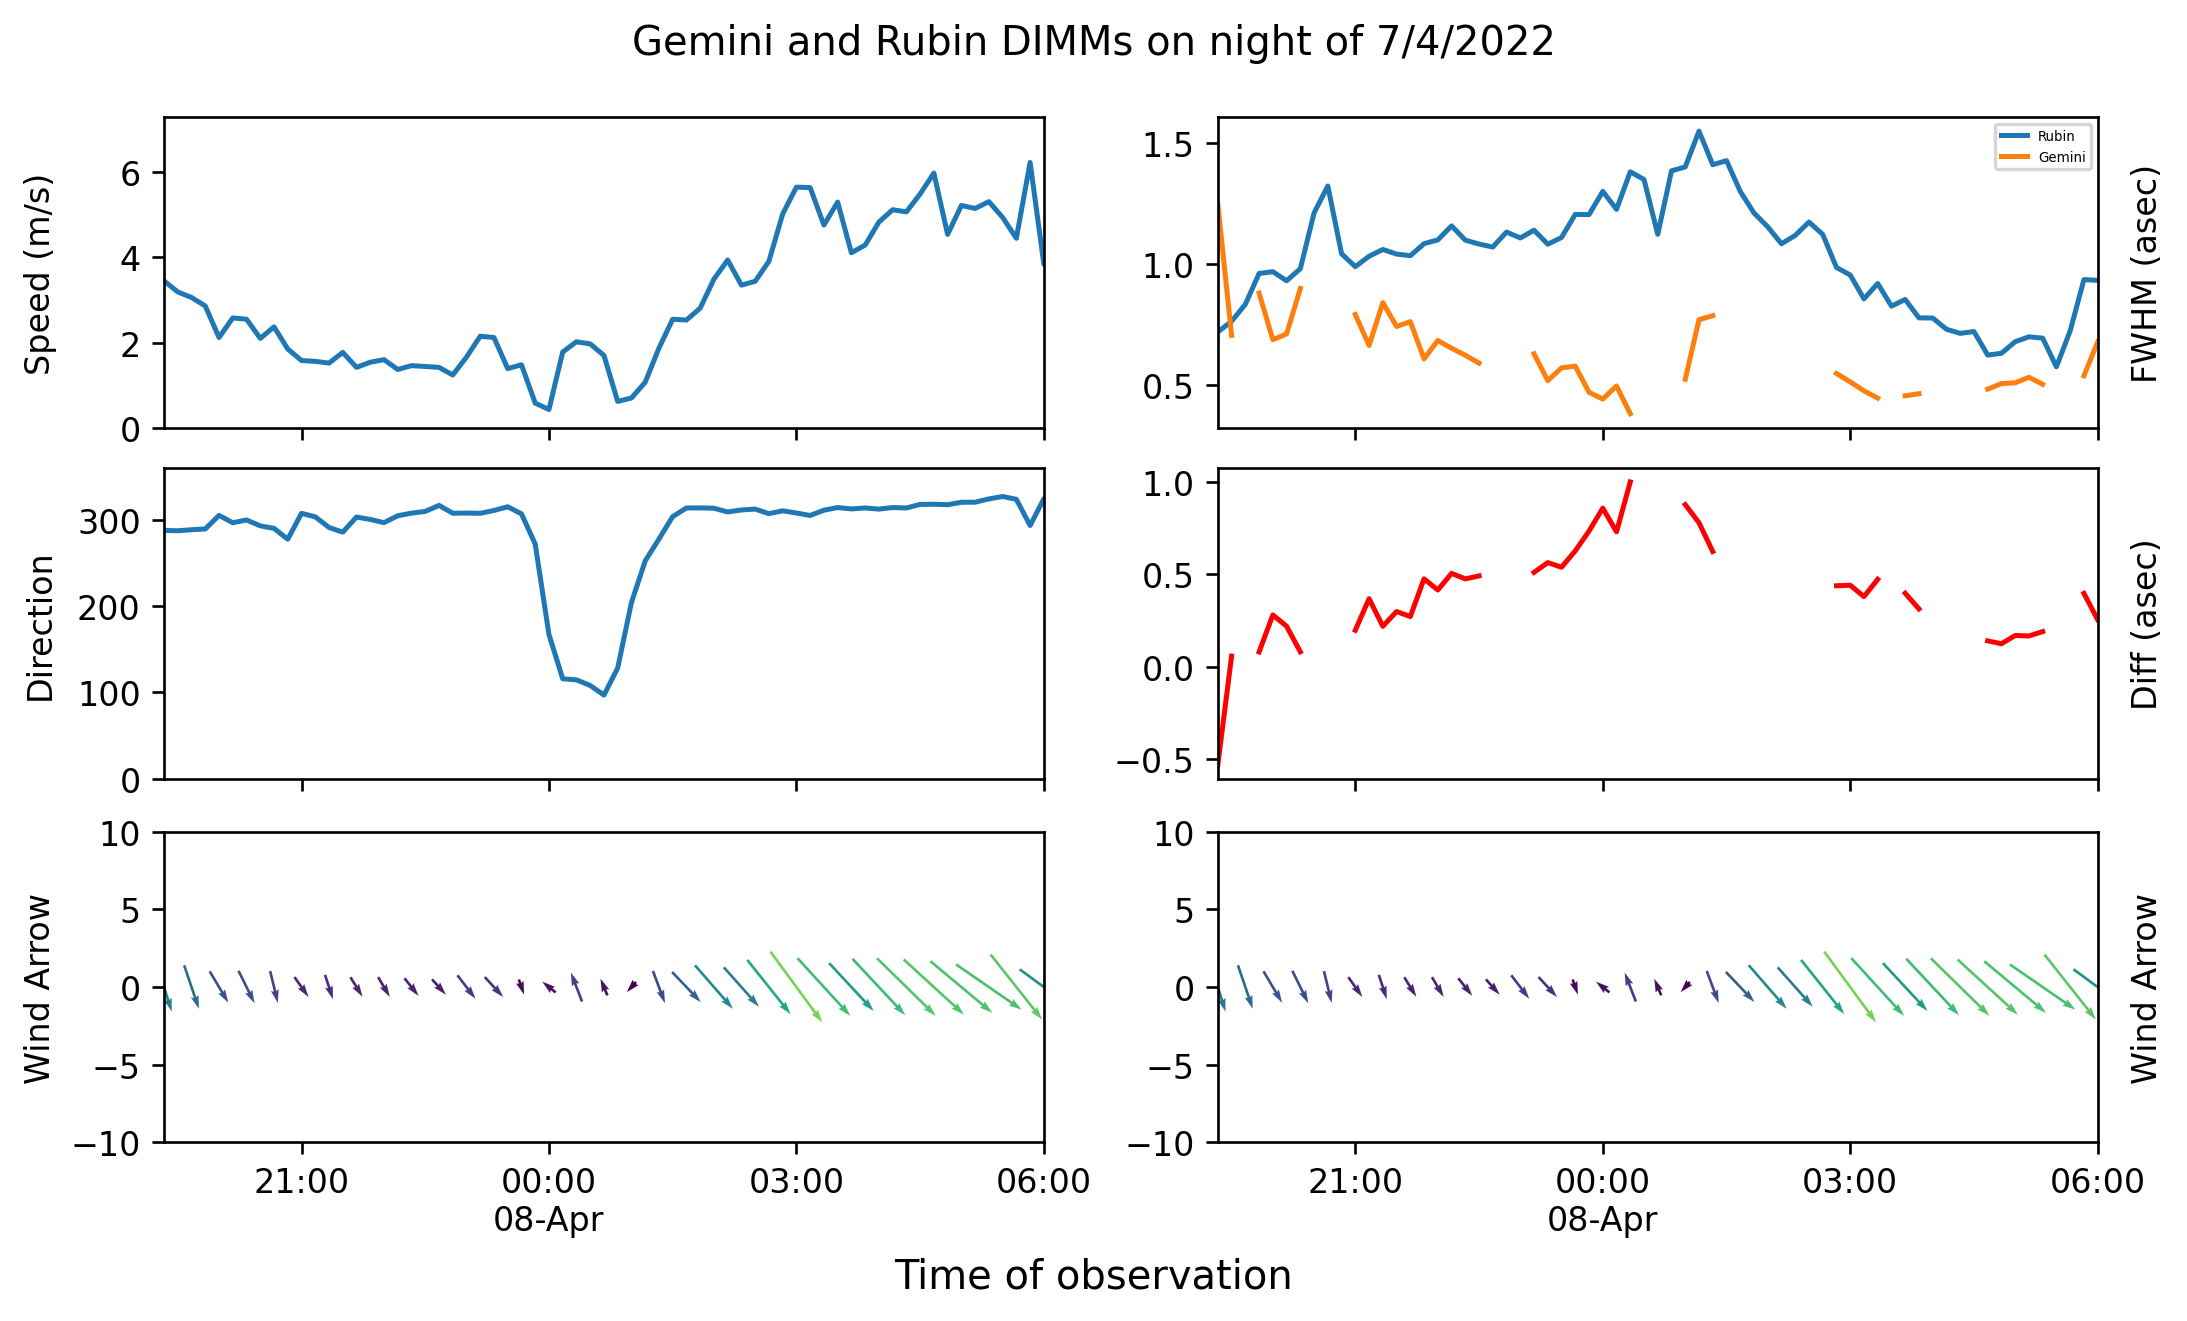

In [63]:
fig, axes = plt.subplot_mosaic('AD;BE;CF', sharex=True, sharey=False, constrained_layout=True, figsize=(9, 5))

# Wind
axes['A'].plot(wind_speed)
axes['B'].plot(wind_direction)
axes['C'].quiver(x, y, x_direct.values, y_direct.values, wind_speed_20.values, angles='uv', scale_units='y', scale=1, width=0.003, pivot='mid')

axes['A'].set_ylim(0)
axes['B'].set_ylim(0,360)

fancy_date_axis(axes['C'])
axes['C'].set_xlim(x[0], x[-1])
axes['C'].set_ylim(-10, 10)

axes['A'].set_ylabel("Speed (m/s)")
axes['B'].set_ylabel("Direction")
axes['C'].set_ylabel("Wind Arrow")

# Dimms

axes['D'].plot(merged.rubin_fwhm, label='Rubin')
axes['D'].plot(merged.gemini_fwhm, label='Gemini')
axes['E'].plot(merged.dimm_diff,color='r' )
axes['F'].quiver(x, y, x_direct.values, y_direct.values, wind_speed_20.values, angles='uv', scale_units='y', scale=1, width=0.003, pivot='mid')


axes['D'].yaxis.set_label_position("right")
axes['E'].yaxis.set_label_position("right")
axes['F'].yaxis.set_label_position("right")

fancy_date_axis(axes['C'])
axes['F'].set_xlim(merged.rubin_fwhm.index[0], merged.rubin_fwhm.index[-1])
axes['F'].set_ylim(-10,10);

axes['D'].legend(fontsize=4)
axes['D'].set_ylabel(r'FWHM (asec)', labelpad=10)
axes['E'].set_ylabel('Diff (asec)', labelpad=10)
axes['F'].set_ylabel('Wind Arrow', labelpad=10)

fig.suptitle(f'Gemini and Rubin DIMMs on night of {day}/{month}/{year}', y=1.07)
fig.supxlabel("Time of observation");
fig.align_ylabels()